# Assignment 2 - Recurrent Neural Network Dynamics 

This coursework is a study of how well a recurrent network model of primary visual cortex (V1) can represent specific features (we will use the example of orientation) of a brief visual stimulus, in the face of readout noise, depending on its connectivity.

We will begin with the experimental set up:

## Technical Set Up

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit



## Experimental Set Up

### Default Parameters

In [79]:
tau = 20 # characteristic neuron time constant (in ms)

m = 200 # number of regularly spaced orientations

n = 200 # number of neuronal inputs

B = np.eye(m,n) # feedforward input weights

C = np.eye(m,n) # matrix of output weights

sigma = 1 # noise of readout activity 

k = np.pi/4 # encoder constant

alpha = 0.9 # recurrent connection strength constant 1

alpha_prime = 0.9 # recurrent connection strength constant 2

phi = 2 * np.pi * np.linspace(0,1,m) # grid of regularly spaced parameters

dt = 1 # timestep (in ms)

### Default Functions

In [59]:
# Tuning Function
def V(z):
    return np.exp( (np.cos(z)-1) * k**(-2))


# Input Encoding Function
def h(theta):
    return V(phi-theta)


# Euler Discretised Update Function
def update_r(r_t, t, W, B, h_theta, tau, dt):
    delta_input = (B @ h_theta) / dt if t == 0 else 0
    drdt = -r_t + W @ r_t + delta_input
    return r_t + (dt/tau) * drdt


# Noisy Readout of V1 Activity
def o_tilde(C, r_t, sigma):
    noise = np.random.normal(0,1, size = len(r_t))
    return C @ r_t + sigma * noise 


# Noisy Readout Decoding
def theta_hat(phi, o_tilde):
    x = np.sum(o_tilde * np.sin(phi))
    y = np.sum(o_tilde * np.cos(phi))
    return np.arctan2(y,x)


# Circular Distance 
def d(theta_hat, theta):
    return np.arccos(np.cos(theta_hat-theta))

# Rescale matrix W_raq to the spectral radius equals alpha
def R(W_raw, alpha):
    eigvals = np.linalg.eigvals(W_raw)
    spectral_radius = np.max(np.abs(eigvals))
    return (alpha / spectral_radius) * W_raw

## Overall Simulation Code

In [82]:
def run_simulation(theta, phi, time_steps, W, B, C, sigma, tau, dt, k):
    np.random.seed(69)

    # --- Local functions ---
    def V(z):
        return np.exp((np.cos(z) - 1) * k**(-2))

    def h(theta):
        return V(phi - theta)

    def update_r(r_t, t, W, B, h_theta, tau, dt):
        delta_input = (B @ h_theta) / dt if t == 0 else 0
        drdt = -r_t + W @ r_t + delta_input
        return r_t + (dt / tau) * drdt

    def o_tilde_func(C, r_t, sigma):
        noise = np.random.normal(0, 1, size=C.shape[0])  # ✅ match output dimension
        return C @ r_t + sigma * noise

    def theta_hat_func(phi, o_tilde):
        x = np.sum(o_tilde * np.sin(phi))
        y = np.sum(o_tilde * np.cos(phi))
        return np.arctan2(y, x)

    def circ_dist(theta_hat, theta):
        return np.arccos(np.cos(theta_hat - theta))

    # --- Main simulation ---
    h_model = h(theta)
    r_list = [np.zeros(W.shape[0])]

    for i, time in enumerate(time_steps):
        r = update_r(r_list[i], time, W, B, h_model, tau, dt)
        r_list.append(r)

    o_tilde_list = [o_tilde_func(C, r, sigma) for r in r_list]
    theta_hat_list = [theta_hat_func(phi, ot) for ot in o_tilde_list]
    circ_d_list = [circ_dist(th, theta) for th in theta_hat_list]

    return circ_d_list, theta_hat_list, o_tilde_list, r_list


## Different Models of Recurrence

### **Model 1: no recurrence**
For this model, $n = m$ and $W^{(1)} = 0_m$ (the $m \times m$ matrix full of zeros).

---

### **Model 2: random symmetric connectivity**
For this model, $n = m$ and  
$$
W^{(2)} = \mathcal{R}(\tilde{W} + \tilde{W}^\top, \alpha)
$$  
with $\tilde{W}_{ij} \sim \mathcal{N}(0, 1)$ i.i.d.  
The random weights will be generated once and for all before any simulation of the network dynamics with various $\theta$'s.

---

### **Model 3: symmetric ring structure**
For this model, $n = m$ and  
$$
W^{(3)} = \mathcal{R}(\tilde{W}, \alpha)
$$  
with $\tilde{W}_{ij} = \mathcal{V}(\phi_i - \phi_j)$, where $\{ \phi_i \}$ and $\mathcal{V}(\cdot)$ have been defined previously.

---

### **Model 4: balanced ring structure**
For this model, $n = 2m$, and  
$$
W^{(4)} = 
\begin{pmatrix}
\tilde{W} & -\tilde{W} \\
\tilde{W} & -\tilde{W}
\end{pmatrix}
$$  
with $\tilde{W}_{ij} = \mathcal{R}(W^{(3)}, \alpha')$.  
As $n = 2m$, we can no longer use $B = C = I$ as in Table 1. Instead, we use:

$$
B = \begin{pmatrix} I_m \\ 0_m \end{pmatrix}, \quad 
C = (I_m, 0_m)
$$

where $I_m$ denotes the $m \times m$ identity matrix.


## Questions and Experiments

### Question 1 - Integrating the Dynamics of the 4 different Models

In [61]:
theta = np.pi # Input orientation 
time_steps = [0,20,60] # Time steps through which we integrate 

#### Model 1: No Recurrence

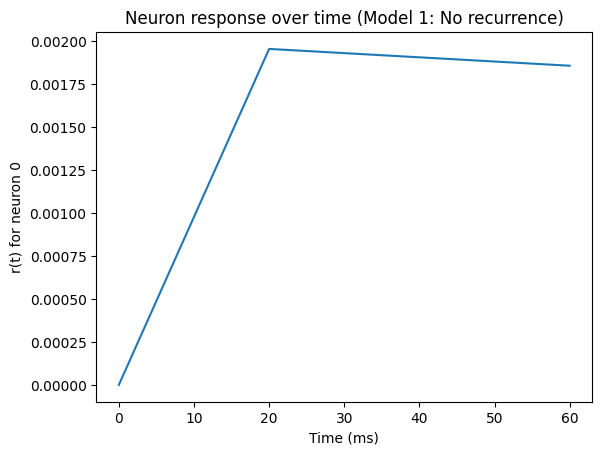

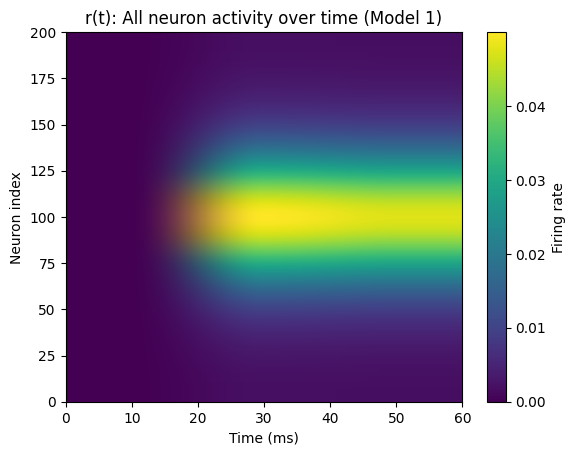

In [96]:
# --- Model 1: No recurrence ---
W_1 = np.zeros_like(B)  # Zero recurrent weights

# Run the simulation
circ_d_w1, theta_hat_list_w1, o_tilde_list_w1, r_list_w1 = run_simulation(
    theta, phi, time_steps, W_1, B, C, sigma, tau, dt, k
)

# Plot response of a single neuron over time
neuron_index = 0
r_values_w1 = [r[neuron_index] for r in r_list_w1[:-1]]  # Exclude final unused timestep
plt.plot(time_steps, r_values_w1)
plt.xlabel("Time (ms)")
plt.ylabel(f"r(t) for neuron {neuron_index}")
plt.title("Neuron response over time (Model 1: No recurrence)")
plt.show()

# Heatmap for all neurons
r_array_w1 = np.array(r_list_w1[:-1])  # shape (time, neurons)
plt.imshow(r_array_w1.T, aspect='auto', origin='lower', extent=[0, time_steps[-1], 0, r_array_w1.shape[1]])
plt.colorbar(label="Firing rate")
plt.xlabel("Time (ms)")
plt.ylabel("Neuron index")
plt.title("r(t): All neuron activity over time (Model 1)")
plt.show()


#### Model 2: Random Symmetric Connectivity

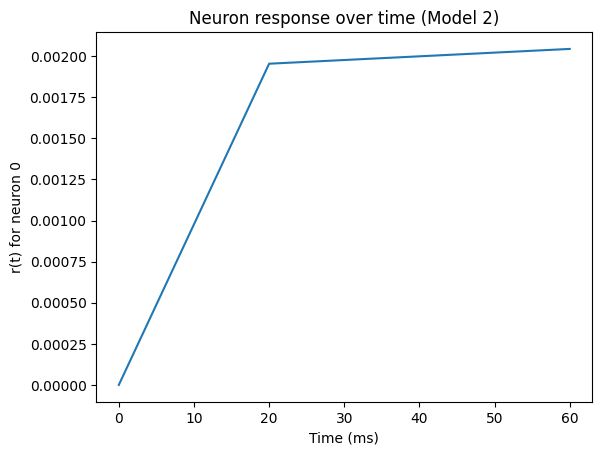

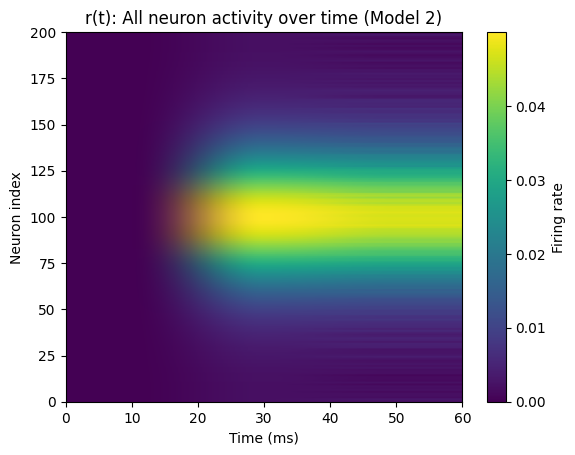

In [84]:
# Model 2: Random symmetric connectivity
W_tilde = np.random.normal(0, 1, size=B.shape)
W_2 = R(W_tilde + W_tilde.T, alpha)

# Run the simulation for theta = π
theta = np.pi
circ_d_w2, theta_hat_list_w2, o_tilde_list_w2, r_list_w2 = run_simulation(
    theta, phi, time_steps, W_2, B, C, sigma, tau, dt, k
)

# Plot neuron 0's response over time
neuron_index = 0
r_values = [r[neuron_index] for r in r_list_w2[:-1]]
plt.plot(time_steps, r_values)
plt.xlabel("Time (ms)")
plt.ylabel(f"r(t) for neuron {neuron_index}")
plt.title("Neuron response over time (Model 2)")
plt.show()

# Plot full r(t) as heatmap
r_array = np.array(r_list_w2[:-1])
plt.imshow(r_array.T, aspect='auto', origin='lower', extent=[0, time_steps[-1], 0, r_array.shape[1]])
plt.colorbar(label="Firing rate")
plt.xlabel("Time (ms)")
plt.ylabel("Neuron index")
plt.title("r(t): All neuron activity over time (Model 2)")
plt.show()


#### Model 3: Symmetric Ring Structure

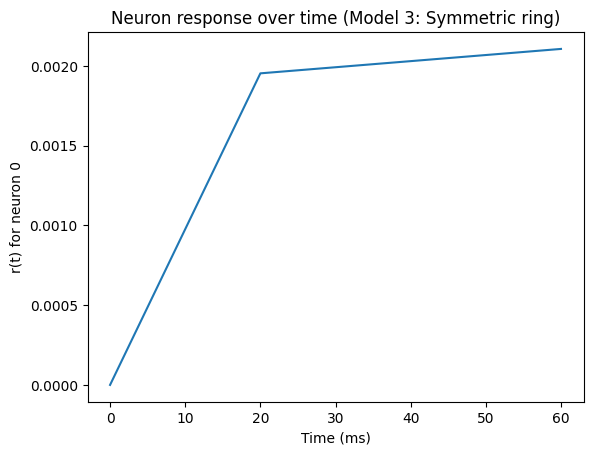

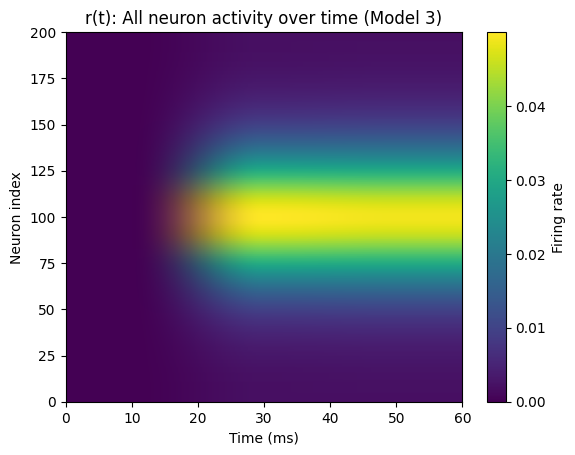

In [85]:
W_ij = np.zeros_like(B)
for i in range(n):
    for j in range(n):
        W_ij[i,j] = V(phi[i]-phi[j])

W_3 = R(W_ij, alpha)

# Run the simulation
circ_d_w3, theta_hat_list_w3, o_tilde_list_w3, r_list_w3 = run_simulation(
    theta, phi, time_steps, W_3, B, C, sigma, tau, dt, k
)

# Plot response of a single neuron
neuron_index = 0
r_values_w3 = [r[neuron_index] for r in r_list_w3[:-1]]
plt.plot(time_steps, r_values_w3)
plt.xlabel("Time (ms)")
plt.ylabel(f"r(t) for neuron {neuron_index}")
plt.title("Neuron response over time (Model 3: Symmetric ring)")
plt.show()

# Heatmap
r_array_w3 = np.array(r_list_w3[:-1])
plt.imshow(r_array_w3.T, aspect='auto', origin='lower', extent=[0, time_steps[-1], 0, r_array_w3.shape[1]])
plt.colorbar(label="Firing rate")
plt.xlabel("Time (ms)")
plt.ylabel("Neuron index")
plt.title("r(t): All neuron activity over time (Model 3)")
plt.show()


#### Model 4: Balanced Ring Structure

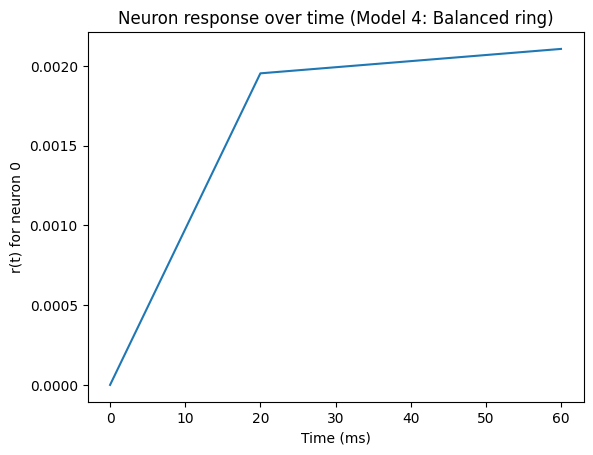

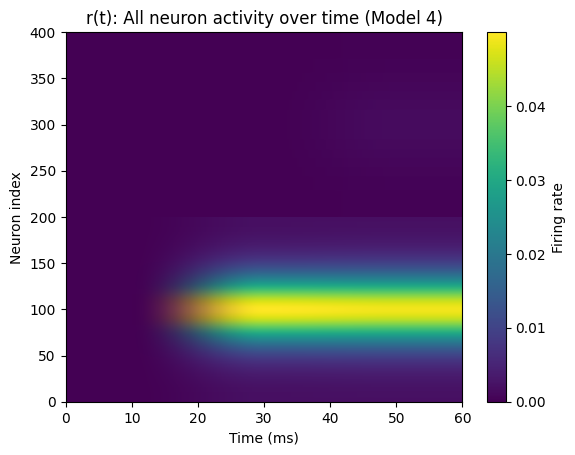

In [86]:
# --- Model 4: Balanced Ring Structure ---
m = len(phi)
phi_diff = phi[:, None] - phi[None, :]
W_tilde = np.exp((np.cos(phi_diff) - 1) * k**(-2))
W_tilde = R(W_tilde, alpha_prime)

# Create block matrix
top = np.hstack((W_tilde, -W_tilde))
bottom = np.hstack((W_tilde, -W_tilde))
W_4 = np.vstack((top, bottom))  # shape: (2m, 2m)

# New B and C matrices
I_m = np.eye(m)
Z_m = np.zeros_like(I_m)
B_4 = np.vstack((I_m, Z_m))       # shape: (2m, m)
C_4 = np.hstack((I_m, Z_m))       # shape: (m, 2m)

# New Phi Vector
phi = 2 * np.pi * np.linspace(0,1,m) # grid of regularly spaced parameters

# Run the simulation
circ_d_w4, theta_hat_list_w4, o_tilde_list_w4, r_list_w4 = run_simulation(
    theta, phi, time_steps, W_4, B_4, C_4, sigma, tau, dt, k
)

# Plot response of a single neuron (in top half)
neuron_index = 0
r_values_w4 = [r[neuron_index] for r in r_list_w4[:-1]]
plt.plot(time_steps, r_values_w4)
plt.xlabel("Time (ms)")
plt.ylabel(f"r(t) for neuron {neuron_index}")
plt.title("Neuron response over time (Model 4: Balanced ring)")
plt.show()

# Heatmap
r_array_w4 = np.array(r_list_w4[:-1])
plt.imshow(r_array_w4.T, aspect='auto', origin='lower', extent=[0, time_steps[-1], 0, r_array_w4.shape[1]])
plt.colorbar(label="Firing rate")
plt.xlabel("Time (ms)")
plt.ylabel("Neuron index")
plt.title("r(t): All neuron activity over time (Model 4)")
plt.show()


### Question 2: Investigations into Model 2

We begin by investigating the variance against time for all 4 fitted models, presuming that at each discretised time step we can fit a Gaussian. We then measure the "noise" as the difference between the actual activity and the fitted Gaussian: the residual. We then compute the standard deviation of the residuals for each model over time - thus capturing irregularities and small-scale noise.

In [93]:
def gaussian(x, A, mu, sigma, baseline):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2)) + baseline

def fit_gaussians_over_time(r_array, phi):
    r_array = np.array(r_array[:-1])
    sigma_list = []
    residual_std_list = []

    for r_t in r_array:
        try:
            A0 = np.max(r_t)
            mu0 = phi[np.argmax(r_t)]
            sigma0 = 0.5
            baseline0 = np.min(r_t)
            popt, _ = curve_fit(gaussian, phi, r_t, p0=[A0, mu0, sigma0, baseline0])
            fitted = gaussian(phi, *popt)
            residuals = r_t - fitted
            sigma_list.append(popt[2])
            residual_std_list.append(np.std(residuals))
        except RuntimeError:
            sigma_list.append(np.nan)
            residual_std_list.append(np.nan)

    return np.array(sigma_list), np.array(residual_std_list)


/var/folders/8m/mlfdjz4d5bd1hd67c6nkhb_00000gn/T/ipykernel_75341/335916710.py:15: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(gaussian, phi, r_t, p0=[A0, mu0, sigma0, baseline0])


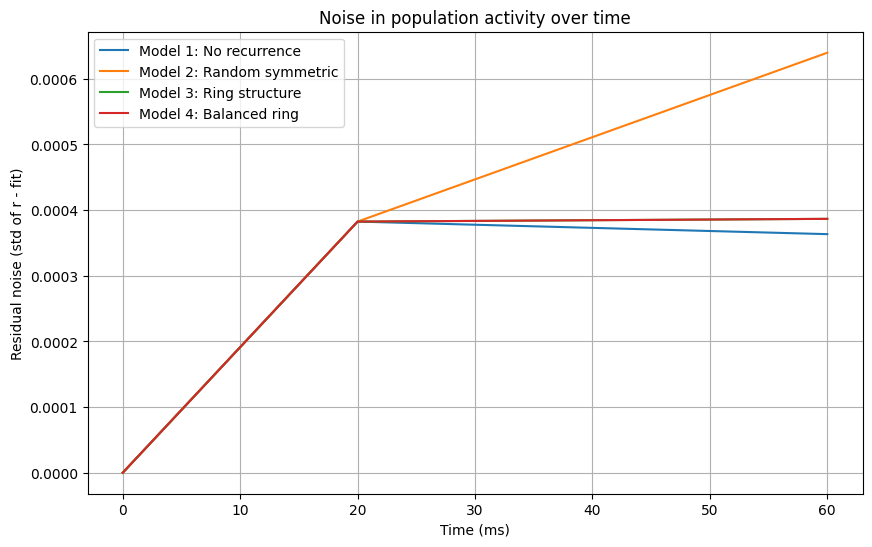

In [94]:
sigma_t_1, resid_t_1 = fit_gaussians_over_time(r_list_w1, phi)
sigma_t_2, resid_t_2 = fit_gaussians_over_time(r_list_w2, phi)
sigma_t_3, resid_t_3 = fit_gaussians_over_time(r_list_w3, phi)
sigma_t_4, resid_t_4 = fit_gaussians_over_time([r[:len(phi)] for r in r_list_w4], phi)

plt.figure(figsize=(10, 6))
plt.plot(time_steps, resid_t_1, label="Model 1: No recurrence")
plt.plot(time_steps, resid_t_2, label="Model 2: Random symmetric")
plt.plot(time_steps, resid_t_3, label="Model 3: Ring structure")
plt.plot(time_steps, resid_t_4, label="Model 4: Balanced ring")

plt.xlabel("Time (ms)")
plt.ylabel("Residual noise (std of r - fit)")
plt.title("Noise in population activity over time")
plt.legend()
plt.grid(True)
plt.show()



### 🧮 Eigendecomposition of the Recurrent Dynamics

The post-input dynamics of the network are governed by:

$$
\frac{dr(t)}{dt} = -r(t) + W r(t)
$$

Define the effective dynamics matrix:

$$
A := -I + W
$$

If $A \in \mathbb{R}^{m \times m}$ is diagonalizable, we can write:

$$
A = Q \Lambda Q^{-1}
$$

Where:
- $Q$ contains the eigenvectors of $A$
- $\Lambda$ is a diagonal matrix of eigenvalues $\lambda_1, \dots, \lambda_m$

If $W$ is **symmetric** (as in Model 2), then:
- $Q$ is orthogonal: $Q^{-1} = Q^\top$
- So:

$$
A = Q \Lambda Q^\top
$$

The solution to the dynamics becomes:

$$
r(t) = Q \, e^{\Lambda t} \, Q^\top r(0)
$$

Each eigenmode $q_i$ evolves as:

$$
r_i(t) = e^{\lambda_i t} \langle q_i, r(0) \rangle
$$

---

### 💡 Interpretation for Model 2

In Model 2:
- $W$ is based on a **random symmetric matrix**, so its eigenvectors are not aligned with the input bump
- Even though the spectral radius is normalised, **noisy eigenmodes** can be amplified
- The dynamics can evolve in irregular directions, producing **greater residual noise** and **less structured responses**

This explains the **growing deviation from smooth Gaussian profiles** in Model 2's activity, as observed in the residual error plots.


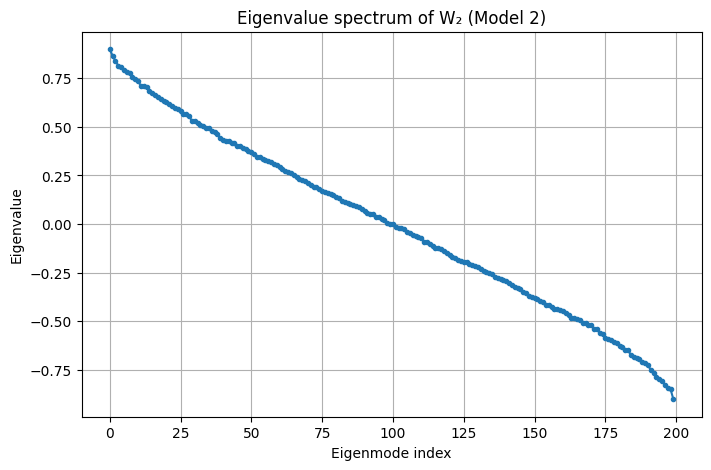

In [97]:
eigvals, eigvecs = np.linalg.eigh(W_2)

plt.figure(figsize=(8, 5))
plt.plot(np.sort(eigvals)[::-1], '.-')
plt.xlabel("Eigenmode index")
plt.ylabel("Eigenvalue")
plt.title("Eigenvalue spectrum of W₂ (Model 2)")
plt.grid(True)
plt.show()


### Question 3: Investigation into Model 3